# Learning to identify important repositories using graphical analysis on historical data

In the [graph analysis notebook](./graph_analysis.ipynb), we explored relationships between open source projects and communities by studying graphs. We explored relations such as common contributors and project activities between different GitHub repositories.

In this notebook, our aim is to leverage the graph representation techniques we explored in the previous notebook and apply algorithms such as PageRank, Betweenness Centrality to find important emerging projects.

In order to do that, we test these algorithms on historical data of well known open source project communities such as OpenShift and Kubernetes.

## Connect to Augur database

We will be fetching the data from an Augur database which stores the GitHub data for a large number of open source repositories.

In [1]:
# !pip install psycopg2

In [2]:
import psycopg2
import pandas as pd
import collections
import datetime
from operator import itemgetter

import sqlalchemy as salc
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

with open("../../comm_cage.json") as config_file:
    config = json.load(config_file)

In [3]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Retrieve Available Repositories for OpenShift and Kubernetes

We start with known project communities during the years [2011-2014](https://developer.ibm.com/blogs/a-brief-history-of-red-hat-openshift/)  and color the project nodes differently as we plot the graphs. We categorize repositories into 3 buckets. 

1. **Well-known**: We categorize Kubernetes and Docker repos in this bucket. We assume that we are aware of the Kubernetes and Docker communities and we wish to reveal related emerging communities which are related to Kubernetes

2. **Emerging**: We categorize OpenShift repos in this bucket. We go forward with the assumption that there is an overlap of contributors between the OpenShift and Kubernetes repositories. We can then apply the graph algorithms for the Kubernetes repos to help discover the OpenShift community.

3. **Other Communities**: In this bucket, we will include other repositories belonging to un-related project communities which either already are important communities or are also emerging in that time frame (2011-2014). We found some popular communities which emerged in the 2011-2014 time range as well as already popular repositories such as Apache Hadoop, Apache Mesos, Node, Eclipse jetty.project.

In [4]:
# Bucketing repositories based on a category

interesting_projects = ['https://github.com/apache/kafka',
                    'https://github.com/torvalds/linux']

rh_affiliated_projects = ['https://github.com/quay/clair',
'https://github.com/quay/quay',
'https://github.com/quay/clair',
'https://github.com/ceph/ceph',
'https://github.com/rook/rook',
'https://github.com/knative/serving',
'https://github.com/knative/docs',
'https://github.com/knative/eventing',
'https://github.com/knative/client',
'https://github.com/knative/pkg',
'https://github.com/knative/community',
'https://github.com/apache/tomcat',
'https://github.com/3scale/APIcast',
'https://github.com/3scale/porta',
'https://github.com/3scale/3scale-amp-openshift-templates',
'https://github.com/3scale/lua-resty-url',
'https://github.com/apache/activemq',
'https://github.com/apache/activemq-artemis',
'https://github.com/apache/activemq-artemis-native',
'https://github.com/apache/activemq-nms-api',
'https://github.com/apache/activemq-nms-amqp',
'https://github.com/apache/activemq-nms-ems',
'https://github.com/apache/activemq-nms-openwire',
'https://github.com/apache/activemq-nms-msmq',
'https://github.com/apache/activemq-nms-stomp',
'https://github.com/apache/activemq-nms-xms',
'https://github.com/apache/activemq-nms-zmq',
'https://github.com/apache/activemq-cli-tools',
'https://github.com/apache/activemq-cpp',
'https://github.com/apache/activemq-website',
'https://github.com/openshift/cluster-monitoring-operator',
'https://github.com/jaegertracing/jaeger',
'https://github.com/jaegertracing/jaeger-operator',
'https://github.com/jaegertracing/jaeger-ui',
'https://github.com/SELinuxProject/selinux',
'https://github.com/SELinuxProject/selinux-notebook',
'https://github.com/SELinuxProject/refpolicy',
'https://github.com/SELinuxProject/setools',
'https://github.com/containers/buildah',
'https://github.com/ansible/ansible',
'https://github.com/ceph/ceph',
'https://github.com/flannel-io/flannel',
'https://github.com/gluster/glusterfs',
'https://github.com/infinispan/infinispan',
'https://github.com/openshift/sriov-cni',
] 

In [5]:
def get_repos(repos):
    
    repo_set = []
    repo_name_set = []
    for repo_git in repos:
        repo_query = salc.sql.text(f"""
                     SET SCHEMA 'augur_data';
                     SELECT 
                        b.repo_id,
                        b.repo_name
                    FROM
                        repo_groups a,
                        repo b
                    WHERE
                        a.repo_group_id = b.repo_group_id AND
                        b.repo_git = \'{repo_git}\'
            """)

        t = engine.execute(repo_query)
        results = t.mappings().all()[0]
        repo_id = results['repo_id']
        repo_name = results['repo_name']
        repo_set.append(repo_id)
        repo_name_set.append(repo_name)
    return repo_set, repo_name_set

In [6]:
repo_set_interesting, repo_name_set_interesting = get_repos(interesting_projects)
print(repo_set_interesting, repo_name_set_interesting)

[29380, 36109] ['kafka', 'linux']


In [7]:
repo_set_rh_affiliated, repo_name_set_rh_affiliated = get_repos(rh_affiliated_projects)
print(repo_set_rh_affiliated, repo_name_set_rh_affiliated)

[31536, 31561, 31536, 35308, 34278, 34798, 34787, 34789, 34791, 34794, 34796, 30361, 33138, 33121, 33126, 33144, 29742, 30483, 28904, 30447, 29934, 30174, 29540, 28755, 28565, 29498, 29784, 28981, 29939, 30163, 32500, 31090, 31103, 31084, 27577, 27579, 27573, 27576, 27037, 28336, 35308, 32856, 35162, 31779, 32432] ['clair', 'quay', 'clair', 'ceph', 'rook', 'serving', 'docs', 'eventing', 'client', 'pkg', 'community', 'tomcat', 'APIcast', 'porta', '3scale-amp-openshift-templates', 'lua-resty-url', 'activemq', 'activemq-artemis', 'activemq-artemis-native', 'activemq-nms-api', 'activemq-nms-amqp', 'activemq-nms-ems', 'activemq-nms-openwire', 'activemq-nms-msmq', 'activemq-nms-stomp', 'activemq-nms-xms', 'activemq-nms-zmq', 'activemq-cli-tools', 'activemq-cpp', 'activemq-website', 'cluster-monitoring-operator', 'jaeger', 'jaeger-operator', 'jaeger-ui', 'selinux', 'selinux-notebook', 'refpolicy', 'setools', 'buildah', 'ansible', 'ceph', 'flannel', 'glusterfs', 'infinispan', 'sriov-cni']


In [8]:
repo_set = repo_set_rh_affiliated + repo_set_interesting 
repo_name_set = repo_name_set_rh_affiliated + repo_name_set_interesting 

In [9]:
print(repo_set, repo_name_set)

[31536, 31561, 31536, 35308, 34278, 34798, 34787, 34789, 34791, 34794, 34796, 30361, 33138, 33121, 33126, 33144, 29742, 30483, 28904, 30447, 29934, 30174, 29540, 28755, 28565, 29498, 29784, 28981, 29939, 30163, 32500, 31090, 31103, 31084, 27577, 27579, 27573, 27576, 27037, 28336, 35308, 32856, 35162, 31779, 32432, 29380, 36109] ['clair', 'quay', 'clair', 'ceph', 'rook', 'serving', 'docs', 'eventing', 'client', 'pkg', 'community', 'tomcat', 'APIcast', 'porta', '3scale-amp-openshift-templates', 'lua-resty-url', 'activemq', 'activemq-artemis', 'activemq-artemis-native', 'activemq-nms-api', 'activemq-nms-amqp', 'activemq-nms-ems', 'activemq-nms-openwire', 'activemq-nms-msmq', 'activemq-nms-stomp', 'activemq-nms-xms', 'activemq-nms-zmq', 'activemq-cli-tools', 'activemq-cpp', 'activemq-website', 'cluster-monitoring-operator', 'jaeger', 'jaeger-operator', 'jaeger-ui', 'selinux', 'selinux-notebook', 'refpolicy', 'setools', 'buildah', 'ansible', 'ceph', 'flannel', 'glusterfs', 'infinispan', 'sr

### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [10]:
issue_contrib = pd.DataFrame()
for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                i.cntrb_id,
                i.issue_id,
                i.created_at
                FROM
                repo r, issues i
                 WHERE
                i.repo_id = \'{repo_id}\' AND
                i.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    issue_contrib = pd.concat([issue_contrib, df_current_repo])

issue_contrib = issue_contrib.reset_index()
issue_contrib.drop("index", axis=1, inplace=True)
issue_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'issue_id', 'created_at']
issue_contrib['cntrb_id'] = issue_contrib['cntrb_id'].astype('Int64')
display(issue_contrib)
issue_contrib.dtypes

,repo_id,repo_git,repo_name,cntrb_id,issue_id,created_at
0,31536,https://github.com/quay/clair,clair,<NA>,730531,2021-12-17 13:28:09
1,31536,https://github.com/quay/clair,clair,<NA>,730587,2021-10-20 14:14:07
2,31536,https://github.com/quay/clair,clair,<NA>,730609,2021-09-23 06:24:25
3,31536,https://github.com/quay/clair,clair,<NA>,730620,2021-09-10 21:03:28
4,31536,https://github.com/quay/clair,clair,<NA>,730650,2021-08-06 21:20:52
...,...,...,...,...,...,...
268419,36109,https://github.com/torvalds/linux,linux,<NA>,37250,2011-09-05 21:37:49
268420,36109,https://github.com/torvalds/linux,linux,<NA>,37251,2011-09-05 21:17:10
268421,36109,https://github.com/torvalds/linux,linux,<NA>,37252,2011-09-05 18:46:20
268422,36109,https://github.com/torvalds/linux,linux,<NA>,37253,2011-09-05 17:45:59


repo_id               object
repo_git              object
repo_name             object
cntrb_id               Int64
issue_id              object
created_at    datetime64[ns]
dtype: object

In [11]:
issue_contrib['created_at_dt'] = issue_contrib['created_at'].dt.date

In [12]:
date_range = (issue_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (issue_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
issue_contrib = issue_contrib.loc[date_range]

In [13]:
issue_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,issue_id,created_at,created_at_dt
4496,35308,https://github.com/ceph/ceph,ceph,<NA>,2217598,2013-03-23 19:21:06,2013-03-23
4498,35308,https://github.com/ceph/ceph,ceph,<NA>,2217639,2013-03-20 01:33:48,2013-03-20
4499,35308,https://github.com/ceph/ceph,ceph,<NA>,2217600,2013-03-23 01:01:00,2013-03-23
4500,35308,https://github.com/ceph/ceph,ceph,<NA>,2217602,2013-03-22 20:30:15,2013-03-22
4501,35308,https://github.com/ceph/ceph,ceph,<NA>,2217603,2013-03-22 20:27:31,2013-03-22


### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [14]:
pr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                prm.cntrb_id,
                prm.pull_request_id,
                pr.pr_created_at
                FROM
                repo r, pull_request_meta prm, pull_requests pr
                WHERE
                prm.repo_id = \'{repo_id}\' AND
                prm.repo_id = r.repo_id AND
                prm.pull_request_id = pr.pull_request_id
                LIMIT 50000
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
pr_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'pull_request_id', 'pr_created_at']
pr_contrib['cntrb_id'] = pr_contrib['cntrb_id'].astype('Int64')
display(pr_contrib)
pr_contrib.dtypes

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at
0,31536,https://github.com/quay/clair,clair,2214763,2041522,2022-08-15 16:51:30
1,31536,https://github.com/quay/clair,clair,2204327,2041522,2022-08-15 16:51:30
2,31536,https://github.com/quay/clair,clair,2204320,2041523,2022-08-04 18:32:21
3,31536,https://github.com/quay/clair,clair,2204327,2041523,2022-08-04 18:32:21
4,31536,https://github.com/quay/clair,clair,2214763,2041524,2022-08-02 17:10:32
...,...,...,...,...,...,...
203178,36109,https://github.com/torvalds/linux,linux,25650,27248,2020-03-02 12:16:22
203179,36109,https://github.com/torvalds/linux,linux,39757,27246,2020-02-28 17:38:00
203180,36109,https://github.com/torvalds/linux,linux,25650,27246,2020-02-28 17:38:00
203181,36109,https://github.com/torvalds/linux,linux,38903,26939,2017-10-05 08:39:55


repo_id                    object
repo_git                   object
repo_name                  object
cntrb_id                    Int64
pull_request_id            object
pr_created_at      datetime64[ns]
dtype: object

In [15]:
pr_contrib['created_at_dt'] = pr_contrib['pr_created_at'].dt.date

In [16]:
date_range = (pr_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (pr_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
pr_contrib = pr_contrib.loc[date_range]

In [17]:
pr_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at,created_at_dt
64405,30361,https://github.com/apache/tomcat,tomcat,2241008,1296965,2013-12-16 21:02:37,2013-12-16
64406,30361,https://github.com/apache/tomcat,tomcat,2204176,1296965,2013-12-16 21:02:37,2013-12-16
64407,30361,https://github.com/apache/tomcat,tomcat,2219987,1296967,2014-02-27 00:46:53,2014-02-27
64408,30361,https://github.com/apache/tomcat,tomcat,2204176,1296967,2014-02-27 00:46:53,2014-02-27
64409,30361,https://github.com/apache/tomcat,tomcat,2249923,1296968,2014-04-14 05:56:23,2014-04-14


### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [18]:
commit_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                ca.cntrb_id,
                c.cmt_id,
                c.cmt_date_attempted
                FROM
                repo r, commits c, contributors_aliases ca
                WHERE
                c.repo_id = \'{repo_id}\' AND
                c.repo_id = r.repo_id and
                c.cmt_committer_email = ca.alias_email
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    commit_contrib = pd.concat([commit_contrib, df_current_repo])

commit_contrib = commit_contrib.reset_index()
commit_contrib.drop("index", axis=1, inplace=True)
commit_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'cmt_id', 'cmt_date_attempted']
commit_contrib['cntrb_id'] = commit_contrib['cntrb_id'].astype('Int64')
display(commit_contrib)
commit_contrib.dtypes

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted
0,31536,https://github.com/quay/clair,clair,92894,28434467,2018-01-12
1,31536,https://github.com/quay/clair,clair,92894,28434468,2018-01-12
2,31536,https://github.com/quay/clair,clair,2215673,28434458,2019-03-14
3,31536,https://github.com/quay/clair,clair,2204300,28434647,2016-01-19
4,31536,https://github.com/quay/clair,clair,2204300,28434700,2016-01-21
...,...,...,...,...,...,...
2694863,36109,https://github.com/torvalds/linux,linux,26481,103832615,2012-07-25
2694864,36109,https://github.com/torvalds/linux,linux,26481,115516451,2012-07-25
2694865,36109,https://github.com/torvalds/linux,linux,26481,115663268,2012-07-25
2694866,36109,https://github.com/torvalds/linux,linux,26481,103832606,2012-07-25


repo_id                       object
repo_git                      object
repo_name                     object
cntrb_id                       Int64
cmt_id                        object
cmt_date_attempted    datetime64[ns]
dtype: object

In [19]:
commit_contrib['cmt_date_attempted_dt'] = commit_contrib['cmt_date_attempted'].dt.date

In [20]:
date_range = (commit_contrib['cmt_date_attempted_dt'] > pd.to_datetime('2011-01-01')) & (commit_contrib['cmt_date_attempted_dt'] <= pd.to_datetime('2014-06-30'))
commit_contrib = commit_contrib.loc[date_range]

In [21]:
commit_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted,cmt_date_attempted_dt
2308,31561,https://github.com/quay/quay,quay,2204325,6700216,2014-05-27,2014-05-27
2309,31561,https://github.com/quay/quay,quay,2204325,6700817,2014-04-07,2014-04-07
2313,31561,https://github.com/quay/quay,quay,2204325,6701134,2014-05-13,2014-05-13
2314,31561,https://github.com/quay/quay,quay,2204325,6701246,2014-04-11,2014-04-11
2315,31561,https://github.com/quay/quay,quay,2204073,6701804,2014-01-30,2014-01-30


## Graph Type 1: Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributors

In [22]:
df_commit = commit_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_commit

cntrb_id,25650,25737,25760,25796,26078,26079,26109,26197,26281,26390,...,2467201,2539342,2539349,2540598,2545113,2546277,2547367,2555519,2555561,2555610
repo_name,,,,,,,,,,,,,,,,,,,,,
activemq,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ansible,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,10,0,0,0,0
ceph,0,0,0,2,0,0,0,0,0,0,...,12,0,0,0,0,0,0,0,0,0
infinispan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,255
linux,25697,21,2403,0,1748,2981,0,0,89,660,...,0,0,0,154,46,0,51,51,7,0
quay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
refpolicy,0,0,0,0,0,0,0,0,0,0,...,0,6,1,0,0,0,0,0,0,0
selinux,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tomcat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the above dataframe, each row represents a repository ID and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a a number x means that the contributor has made x number of commits to the repository.

In [23]:
df_commit = df_commit.reset_index()

In [24]:
df_commit.head()

cntrb_id,repo_name,25650,25737,25760,25796,26078,26079,26109,26197,26281,...,2467201,2539342,2539349,2540598,2545113,2546277,2547367,2555519,2555561,2555610
0,activemq,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ansible,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,10,0,0,0,0
2,ceph,0,0,0,2,0,0,0,0,0,...,12,0,0,0,0,0,0,0,0,0
3,infinispan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,255
4,linux,25697,21,2403,0,1748,2981,0,0,89,...,0,0,0,154,46,0,51,51,7,0


In [25]:
df_melted_commit = df_commit.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [26]:
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

,repo_name,cntrb_id,number
4,linux,25650,25697
13,linux,25737,21
22,linux,25760,2403
29,ceph,25796,2
40,linux,26078,1748


In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

#### Create melted dataframes for all contribution type dataframes

In [27]:
def created_melted_dfs(df):

    df = df.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
    df = df.reset_index()

    df_melted = df.melt(['repo_name'], var_name = 'cntrb_id',value_name='number')
    df_melted = df_melted[df_melted[df_melted.columns[2]] != 0]
    
    return df_melted

In [28]:
df_melted_pr_contrib = created_melted_dfs(pr_contrib)
df_melted_pr_contrib.head()

,repo_name,cntrb_id,number
2,infinispan,25548,15
10,linux,25650,95
14,infinispan,25761,2
22,linux,26292,1
25,glusterfs,26479,1


In [29]:
df_melted_issue_contrib = created_melted_dfs(issue_contrib)
df_melted_issue_contrib.head()

,repo_name,cntrb_id,number


### Join repositories of all contribution types

Combine dataframes of Issue contributors, PR contributors, PR Reviewers, and Commit Contributors to get aggregated contributor dataframes for each repository

In [30]:
commit_issue = pd.merge(df_melted_commit, df_melted_issue_contrib, how="outer", on=["repo_name", "cntrb_id"])

In [31]:
merged_df = pd.merge(df_melted_pr_contrib, commit_issue, how="outer", on=["repo_name", "cntrb_id"])

In [32]:
col_list= ['number', 'number_x', 'number_y']
merged_df['total_contributions'] = merged_df[col_list].sum(axis=1)
merged_df.drop(col_list, axis=1, inplace=True)

In [33]:
merged_df.head()

,repo_name,cntrb_id,total_contributions
0,infinispan,25548.0,15.0
1,linux,25650.0,25792.0
2,infinispan,25761.0,2.0
3,linux,26292.0,1.0
4,glusterfs,26479.0,1.0


In [34]:
merged_df

,repo_name,cntrb_id,total_contributions
0,infinispan,25548.0,15.0
1,linux,25650.0,25792.0
2,infinispan,25761.0,2.0
3,linux,26292.0,1.0
4,glusterfs,26479.0,1.0
...,...,...,...
1181,ansible,2546277.0,10.0
1182,linux,2547367.0,51.0
1183,linux,2555519.0,51.0
1184,linux,2555561.0,7.0


### Plot Graphs

In [35]:
from matplotlib.pyplot import figure, text

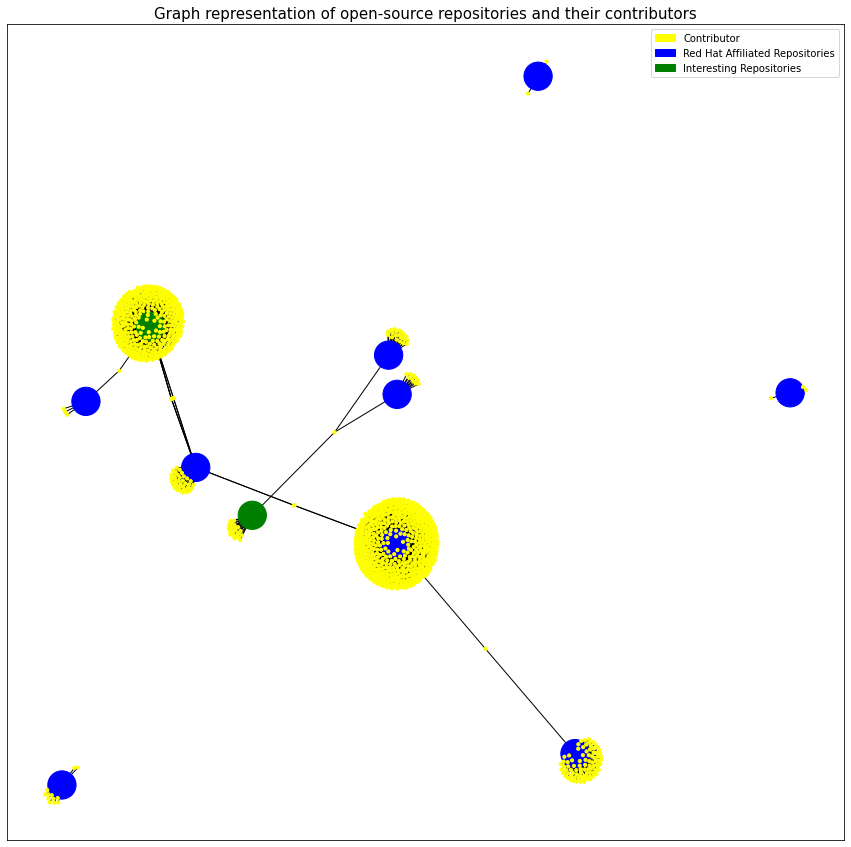

In [36]:
G = nx.from_pandas_edgelist(merged_df, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='total_contributions',
                            create_using=nx.Graph())

Repo_name = merged_df['repo_name'].to_list()
contributor_id = merged_df['cntrb_id'].to_list()

nodes = G.nodes()

colors = []
for n in nodes:
    if n in repo_name_set_rh_affiliated:
        colors.append('blue')
    elif n in repo_name_set_interesting:
        colors.append('green')
    else:
        colors.append('yellow')

node_sizes = [800 if ns in repo_name_set else 10 for ns in nodes]

fig, ax = plt.subplots(figsize=(15,15))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Red Hat Affiliated Repositories')
green_patch = mpatches.Patch(color='green', label='Interesting Repositories')

font = {"color": "k", "fontsize": 15}
ax.set_title("Graph representation of open-source repositories and their contributors", font)

ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(G, with_labels=False, node_color=colors, font_size=10, node_size=node_sizes, ax=ax)

***What do we see in this plot?***

Here we see that some of the Kubernetes, Docker & Openshift repositories seem to form a cluster. Some of the other repositories like the jettyproject also seem to have a lot of contributors, but they don't have any links/edges with the Kubernetes repositories. Lets analyze this further.

### Use PageRank and Betweenness Centrality to Subset Nodes

We can now try to run the `PageRank` algorithm to compute the ranking of the nodes in the graph based on the structure of the incoming links. 

We will also look into the betweenness centrality in the graph to compute the shortest-path betweenness centrality for nodes. It measures how often a node occurs on all shortest paths between two nodes. Here we are trying to analyze which are the common repositories that occur on all paths in the graph. 

### Page Rank

PageRank ranks important nodes by analyzing the quantity and quality of the links that point to it. In our case, links that point to repositories come from contributors. A unidirected graph from contributors to repositories will not be able to assign importances to well connected contributors. Hence we will create a bidirected graph where for each connection between a contributor and a repository, there is a 2 way arrow.

Thus, we hope that PageRank ranks important repositories by analyzing the number of contributors connected to it as well as consider how well connected those contributors are within the network.

In [37]:
bidirect_df = merged_df.append(merged_df.rename(columns={"repo_name":"cntrb_id","cntrb_id":"repo_name"}))

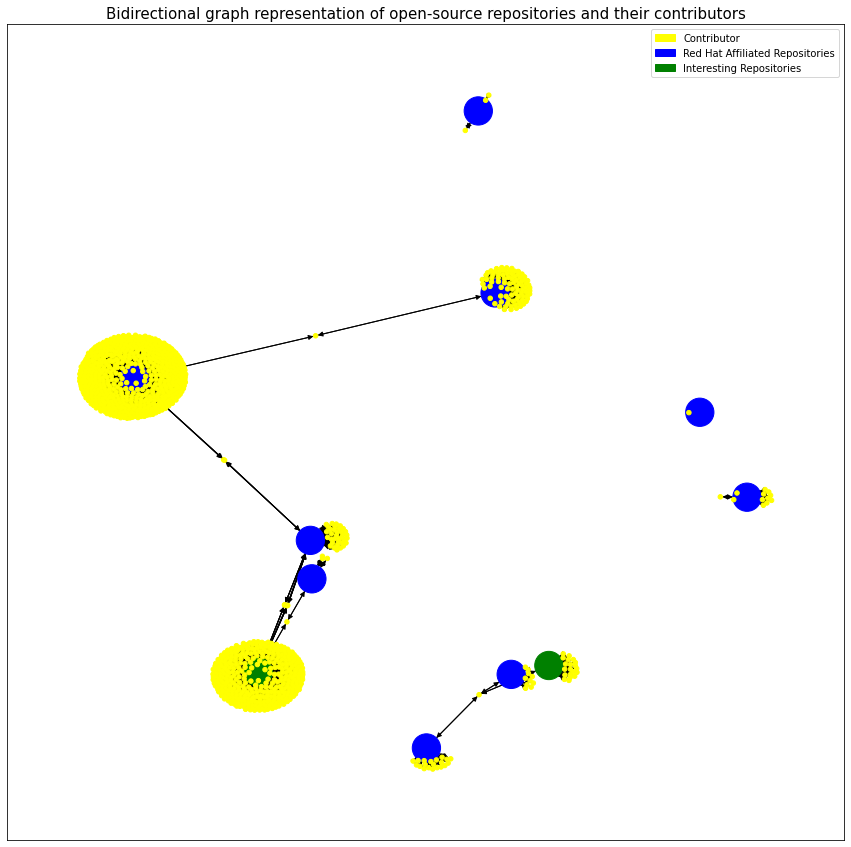

In [38]:
#Creating a directed graph to run page rank
H = nx.from_pandas_edgelist(bidirect_df, 
                            source='cntrb_id',
                            target='repo_name',
                            edge_attr='total_contributions',
                            create_using=nx.DiGraph())

nodes = H.nodes()

Repo_name = merged_df['repo_name'].to_list()
contributor_id = merged_df['cntrb_id'].to_list()
node_sizes = [800 if ns in repo_name_set else 20 for ns in nodes]

colors = []
for n in nodes:
    if n in repo_name_set_rh_affiliated:
        colors.append('blue')
    elif n in repo_name_set_interesting:
        colors.append('green')
    else:
        colors.append('yellow')
        
fig, ax = plt.subplots(figsize=(15,15))

font = {"color": "k", "fontsize": 15}
ax.set_title("Bidirectional graph representation of open-source repositories and their contributors", font)

ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(H, with_labels=False, node_color=colors, node_size=node_sizes, font_size=9, ax=ax)

***What do we see in this plot?***

This plot is the same graph as the last one, only this one is directed, hence the edges have arrows. Like the previous plot here too docker, openshift and kubernetes repos seem to be connected and the other community repos are disconnected from them.

In [39]:
pageranks = nx.pagerank(H, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

The first input parameter of the method, H, is the NetworkX graph. Undirected graphs will be converted to a directed graph with two directed edges for each undirected edge. The second parameter, alpha, is the damping parameter for PageRank and the default value is 0.85. The fourth parameter, max_iter, is the Maximum number of iterations. The seventh parameter, weight, represents the edge attribute that should be used as the edge weight. If it’s not specified, the weight of all edges will be 1.

In [40]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = True)[:20])

We want to give higher priority to outgoing nodes. So we take 50 nodes with lowest pagerank (most number of connections)

In [41]:
key = topnodes.keys()

In [42]:
subgraph = nx.subgraph(H, key)

In [43]:
nodes = subgraph.nodes()
colors = []
for n in nodes:
    if n in repo_name_set_rh_affiliated:
        colors.append('blue')
    elif n in repo_name_set_interesting:
        colors.append('green')
    else:
        colors.append('yellow')

node_sizes = [1000 if ns in repo_name_set else 50 for ns in nodes]

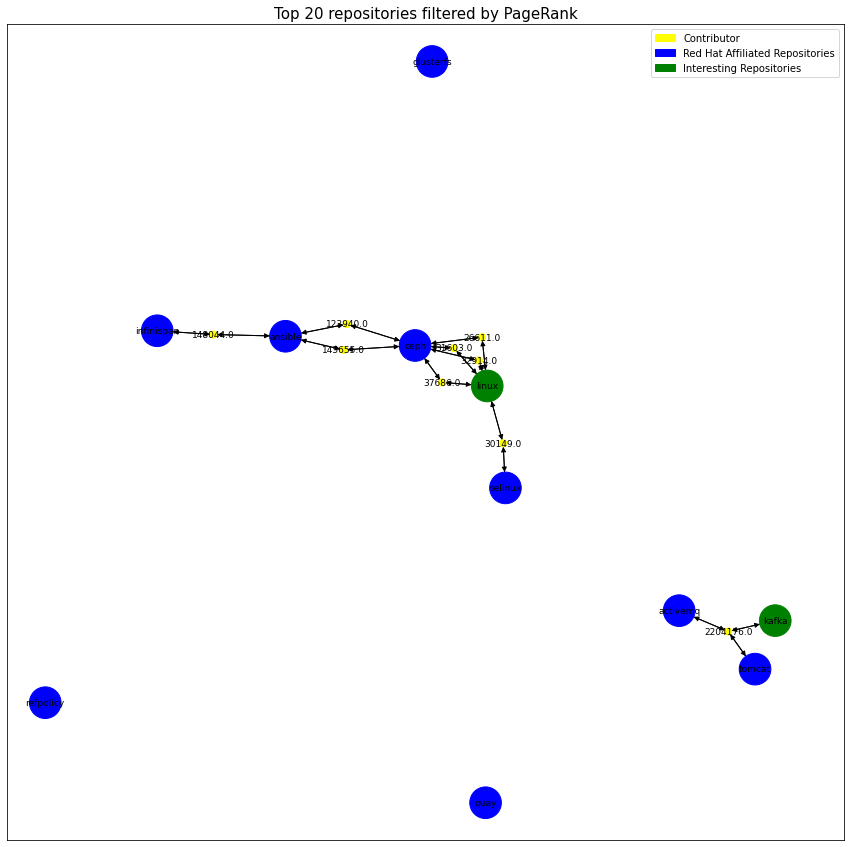

In [44]:
fig, ax = plt.subplots(figsize=(15,15))

font = {"color": "k", "fontsize": 15}
ax.set_title("Top 20 repositories filtered by PageRank", font)

ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(subgraph, node_color=colors, node_size=node_sizes, font_size=9, ax=ax)

***What do we see in this plot?***

Here we see that some contributor nodes have been eliminated from the graph. However, all the repository nodes that we saw previously still remain. As we plot the top 20 nodes ranked by PageRank, it seems to have filtered out a lot of contributor nodes. However, the repo nodes still are top ranked.

Lets look at what are the top 3 nodes

The PageRank algorithm measures the importance of nodes by analyzing the quantity and quality of the links that point to it. So if a repository has a lot of contributors and especially if these contributors count as important nodes, they are still ranked high. 

In [45]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = True)[:3])
topnodes

{'ansible': 0.23562841987282787,
 'linux': 0.14445171638979679,
 'infinispan': 0.03355585507589347}

In [46]:
key = topnodes.keys()
subgraph = nx.subgraph(H, key)
nodes = subgraph.nodes()
colors = []
for n in nodes:
    if n in repo_name_set_rh_affiliated:
        colors.append('blue')
    elif n in repo_name_set_interesting:
        colors.append('green')
    else:
        colors.append('yellow')

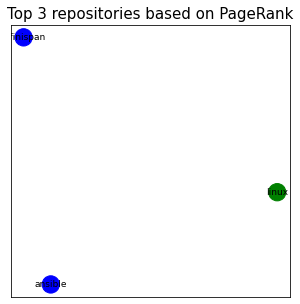

In [47]:
fig, ax = plt.subplots(figsize=(5,5))

font = {"color": "k", "fontsize": 15}
ax.set_title("Top 3 repositories based on PageRank", font)

nx.draw_networkx(subgraph, node_color=colors, font_size=9, ax=ax)

***What do we see in this plot?***

As we plot the top 3 nodes, we see that 2 docker repos, and an unrelated community repo jetty-project show up. 

This is expected as PageRank assigns ranks to repositories by both analyzing the **number** of contributors connected to it as well as how **important those contributors** are within the network.

The docker repos and jetty-project have a much larger number of contributors which seems to be influencing the ranks assigned by PageRank. It seems like PageRank is effective in showing us well-connected and prominent repositories.
**However, PageRank may not be the most effective algorithm here to show us important emerging repositories (here openshift) in connection to existing well-known repos (here docker and kubernetes).**

### Betweenness centrality

Centrality analysis provides information about the node’s importance for an information flow or connectivity of the network. Betweenness centrality measures the extent to which a node lies on paths between other nodes in the graph. Nodes with higher betweenness have more influence within a network. Thus repositories with higher centrality scores can thought to be influential in connection to other repositories in the network.

This is a good metric for us, as using this we are able to better capture relative importance of repositories. In our case since we start with examples of well-known repos, we can use this algorithm to find other repos which are important in connection to these well-known repos.

In [48]:
centrality = nx.betweenness_centrality(G)

In [49]:
sorted( ((v,k) for k,v in centrality.items()), reverse=True)[:50]

[(0.7493891834872848, 'ansible'),
 (0.49233664043790626, 'linux'),
 (0.4315493499828943, 'ceph'),
 (0.20577032728931463, 145655.0),
 (0.20577032728931463, 123940.0),
 (0.12940472117687307, 'infinispan'),
 (0.12565571901014938, 148044.0),
 (0.07825863838522089, 41751.0),
 (0.07825863838522089, 37686.0),
 (0.07825863838522089, 32914.0),
 (0.07825863838522089, 31603.0),
 (0.07825863838522089, 26611.0),
 (0.006312008210742388, 30149.0),
 (0.004742559014710913, 'selinux'),
 (0.0012872049264454329, 2204176.0),
 (0.001211654692667351, 'kafka'),
 (0.001211654692667351, 'activemq'),
 (0.0006771011517846961, 'tomcat'),
 (9.408142319534725e-05, 'glusterfs'),
 (4.276428327061239e-06, 'refpolicy'),
 (1.4254761090204129e-06, 'quay'),
 (0.0, 2577991.0),
 (0.0, 2577987.0),
 (0.0, 2555610.0),
 (0.0, 2555561.0),
 (0.0, 2555519.0),
 (0.0, 2547367.0),
 (0.0, 2546277.0),
 (0.0, 2545113.0),
 (0.0, 2540598.0),
 (0.0, 2539349.0),
 (0.0, 2539342.0),
 (0.0, 2467201.0),
 (0.0, 2400283.0),
 (0.0, 2400281.0),
 (0.

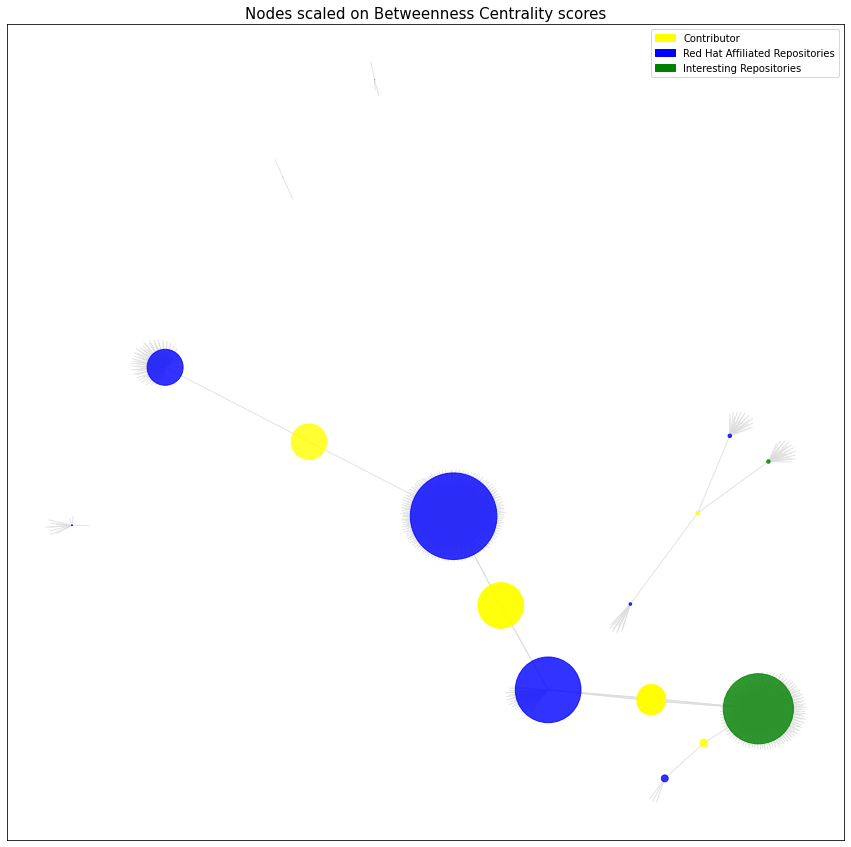

In [50]:
node_sizes = [v * 10000 for v in centrality.values()]

# node_sizes = [1000 if ns in repo_name_set else 50 for ns in nodes]
nodes = G.nodes()

colors = []
for n in nodes:
    if n in repo_name_set_rh_affiliated:
        colors.append('blue')
    elif n in repo_name_set_interesting:
        colors.append('green')
    else:
        colors.append('yellow')

fig, ax = plt.subplots(figsize=(15,15))

ax.legend(handles=[yellow_patch, blue_patch, green_patch])


font = {"color": "k", "fontsize": 15}
ax.set_title("Nodes scaled on Betweenness Centrality scores", font)
nx.draw_networkx(G, node_color=colors, with_labels=False, node_size=node_sizes, font_size=9,  edge_color="gainsboro", ax=ax, alpha=0.8)


***What do we see in this plot?***

The size of the nodes in the plot above indicate higher centrality scores. We see that the centrality scores highly rank the docker, kubernetes and openshift repos. 

Betweenness Centrality gives us good results and is highly ranking openshift repos in comparison to other community repos as this algorithm is able to better capture relative importance of repositories. 

By starting off with well-known repos, centrality is able to help us disvover other repos which are important in connection to these well-known repos.

## Graph Type 2: Nodes as projects edges as contributors

In this section, we represent data in another graph representation where the project repositories are represented by nodes and the edges are shared contributions between those projects

In [51]:
merged_df.head()

,repo_name,cntrb_id,total_contributions
0,infinispan,25548.0,15.0
1,linux,25650.0,25792.0
2,infinispan,25761.0,2.0
3,linux,26292.0,1.0
4,glusterfs,26479.0,1.0


In [52]:
contributorGraph = {}
for i, row in merged_df.iterrows():
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    if(row['total_contributions'] > 0):
        contributorGraph[row['cntrb_id']].append((row['repo_name'], row['total_contributions']))

In [53]:
list(contributorGraph.items())[:20]

[(25548.0, [('infinispan', 15.0)]),
 (25650.0, [('linux', 25792.0)]),
 (25761.0, [('infinispan', 2.0)]),
 (26292.0, [('linux', 1.0)]),
 (26479.0, [('glusterfs', 1.0)]),
 (26637.0, [('linux', 1.0)]),
 (27010.0, [('linux', 1.0)]),
 (27430.0, [('linux', 2.0)]),
 (30165.0, [('linux', 354.0)]),
 (33208.0, [('infinispan', 2.0)]),
 (36015.0, [('infinispan', 11.0)]),
 (39272.0, [('linux', 1.0)]),
 (40126.0, [('linux', 2.0)]),
 (40166.0, [('linux', 1.0)]),
 (40258.0, [('linux', 2.0)]),
 (40264.0, [('linux', 2.0)]),
 (40265.0, [('linux', 1.0)]),
 (40266.0, [('linux', 1.0)]),
 (40267.0, [('linux', 1.0)]),
 (40268.0, [('linux', 1.0)])]

`contributorGraph` above is a dictionary where each key is a contributor, and the value is a list of repositories the contributor has contributed to and the number of contributions it has made.


Hence, if there are more than one repositories in the list that corresponds to a single contributor key, they can be thought of as **"connected"** project repositories and we will now calculate the number of **"shared connections"** between them. 

structure of `contributorGraph` =  
{  
`contributor1`: [(`repo1`, `contributions by the contributor1 in repo 1`)],  
 `contributor2`: [(`repo2`, `contributions by the contributor2 in repo 2` ), (`repo1`, `contributions by the contributor2 in repo 1`)]  
}

**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
This means if they have a contributor who makes a *commit*, *pull request*, *issue* or *pull request review* in both the repositories, they count as a shared contributor and the repositories are connected. 

We track the number of shared contributions between 2 repositories for creating this graph plot.

In [54]:
commonRepoContributionsByContributor = collections.defaultdict(int)
for key in contributorGraph:
    if len(contributorGraph[key])-1 <= 0:
        continue
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
print(commonRepoContributionsByContributor)

defaultdict(<class 'int'>, {('infinispan', 'ansible'): 10.0, ('activemq', 'kafka'): 54.0, ('kafka', 'tomcat'): 35.0, ('ceph', 'linux'): 42967.0, ('linux', 'selinux'): 2047.0, ('ansible', 'ceph'): 11.0})


`commonRepoContributionsByContributor` is a nested dictionary consisting of dictionaries of repository pairs and their common contributions. 

structure of `commonRepoContributionsByContributor` =  
{  
(`repo1, repo2`): `PRs by same authors in repo 1 and repo 2`,  
(`repo2, repo4`): `PRs by same authors in repo 2 and repo 4`,  
(`repo2, repo5`): `PRs by same authors in repo 2 and repo 5`,   
}

In [55]:
res = []
for key in commonRepoContributionsByContributor:
    res.append(tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],))

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [56]:
g = nx.Graph()
g.add_weighted_edges_from(res)

In [57]:
nodes = g.nodes()
colors = []

for n in nodes:
    if n in repo_name_set_rh_affiliated:
        colors.append('blue')
    elif n in repo_name_set_interesting:
        colors.append('green')
    else:
        colors.append('yellow')

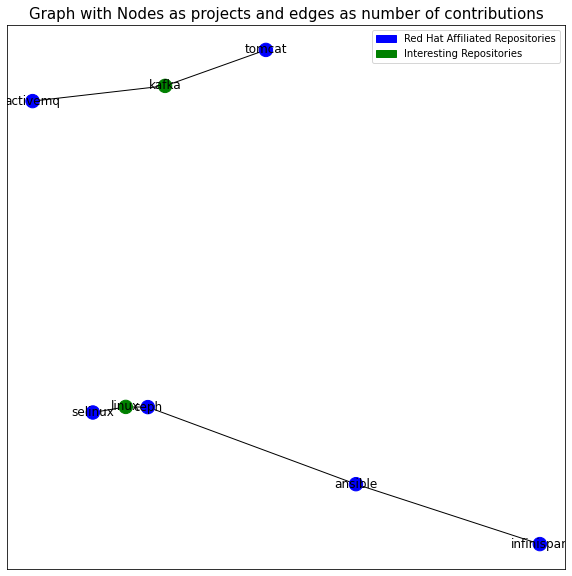

In [59]:
fig, ax = plt.subplots(figsize=(10,10))

font = {"color": "k", "fontsize": 15}
ax.set_title("Graph with Nodes as projects and edges as number of contributions", font)

ax.legend(handles=[blue_patch, green_patch])
nx.draw_networkx(g, node_size=180, node_color=colors, font_size=12, ax=ax)

***What do we see in this plot?***

The above graph represents project repositories and how close or far they are to each other based on their degree of connection (number of shared contributions amongst them). If 2 nodes are close to each other, the 2 projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We only plot project repositories which are connected to existing known repositories.  

We see that this graph representation effectively filters out the repositories we are most interested in seeing. **The repository "closest" to kubernetes and docker repositories are 2 OpenShift repositories "installer" followed by "source-to-image" and "osin" and the other unrelated community repositories do not appear on the plot as they are not "connected" to kubernetes**

Even if there were common contributors between the other repos and our well-known repos, the edge lengths and the distance between the nodes can be used to filter out the most connected repos that we are interested in.

Thus, this graph representation turns out to be an effective way to filter out emerging repositories in relation to already prominent communities.

## Conclusion



In this notebook, we ran an experiment on known open source GitHub repositories. We looked at a timeframe in history where a new open source community was emerging/becoming popular and we tried to track the rise of the community using graph alrgorithms.

As an example, we wanted to track the emergence of OpenShift as the downstream of Kubernetes. So we started with some Kubernetes repos, Docker repos, OpenShift repos and some other unrelated repos with the hope that as a result of the analysis, OpenShift will emerge as the community closest in connection to Kubernetes and Docker, and the other repos although popular or important in their own context do not emerge.

As a result of creating various types of graphical representations of the Github data and using algorithms like PageRank and Betweenness centrality, we saw that:

1. **PageRank is not effective in showing us important emerging OpenShift repositories in relation to Kubernetes and Docker.**

2. **Using Betweenness Centrality ranks, we are able to get OpenShift, Kubernetes and Docker repos in the top most highly ranked or central repos.**

3. **Using the graph representation type 2 where we represent nodes as projects edges as contributors, we are able to very effectively filter out the repositories we are most interested in seeing ie Kubernetes, Docker and OpenShift repos.**

    **We see that the repositories "closest" to Kubernetes and Docker repos are 3 OpenShift repositories "installer", followed by "source-to-image" followed by "osin" and the other unrelated community repositories do not appear on the plot.**